In [1]:
import spacy
from spacy import displacy
import pandas as pd

###**Loading Dataset**

In [2]:
df = pd.read_csv("politifact_real.csv")
df.head()

,id,news_url,title,tweet_ids
0,politifact14984,http://www.nfib-sbet.org/,National Federation of Independent Business,967132259869487105\t967164368768196609\t967215...
1,politifact12944,http://www.cq.com/doc/newsmakertranscripts-494...,comments in Fayetteville NC,942953459\t8980098198\t16253717352\t1668513250...
2,politifact333,https://web.archive.org/web/20080204072132/htt...,"Romney makes pitch, hoping to close deal : Ele...",NaN
3,politifact4358,https://web.archive.org/web/20110811143753/htt...,Democratic Leaders Say House Democrats Are Uni...,NaN
4,politifact779,https://web.archive.org/web/20070820164107/htt...,"Budget of the United States Government, FY 2008",89804710374154240\t91270460595109888\t96039619...


###**Text Preprocessing**

#####**1.Removing Whitespace, HTML tags and Special Characters**

In [3]:
# Text Preprocessing
import re

def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Normalize text
    return text


print(df.columns)
df['cleaned_text'] = df['title'].apply(preprocess_text)

Index(['id', 'news_url', 'title', 'tweet_ids'], dtype='object')


#####**2.Coverting to LowerCase**

In [4]:
if 'title' in df.columns:
    title = df['title'].apply(lambda x:x.lower() if isinstance(x, str) else x)
    print(title.head())
else:
    print("The column does not exist")

0          national federation of independent business
1                          comments in fayetteville nc
2    romney makes pitch, hoping to close deal : ele...
3    democratic leaders say house democrats are uni...
4      budget of the united states government, fy 2008
Name: title, dtype: object


#####**3.Tokenizing the text and removing stop words**

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
import nltk

nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if pd.isnull(text):
        return text

    words = word_tokenize(str(text))  # Tokenize the text into words
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]  # Remove stopwords and convert to lowercase
    return ' '.join(filtered_words)  # Join the words back with spaces

if 'title' in df.columns:
    df['title'] = df['title'].apply(remove_stopwords)  # Remove stopwords and convert to lowercase
    print(df['title'].head())
else:
    print("The column 'title' does not exist in the CSV file.")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


0             national federation independent business
1                             comments fayetteville nc
2    romney makes pitch , hoping close deal : elect...
3    democratic leaders say house democrats united ...
4            budget united states government , fy 2008
Name: title, dtype: object


### **Named Entity Recognition & Feature Engineering**

In [8]:
import spacy # Import spacy

nlp = spacy.load("en_core_web_sm") # Load the spaCy model


def extract_entities(text):
    doc = nlp(text)
    entities = {'ORG': 0, 'GPE': 0, 'PERSON': 0}
    for ent in doc.ents:
        if ent.label_ in entities:
            entities[ent.label_] += 1
    return entities

df['entities'] = df['cleaned_text'].apply(extract_entities)
df['ORG_count'] = df['entities'].apply(lambda x: x['ORG'])
df['GPE_count'] = df['entities'].apply(lambda x: x['GPE'])
df['PERSON_count'] = df['entities'].apply(lambda x: x['PERSON'])

### **Predictive Modeling**

In [11]:
# Sentiment Analysis
from textblob import TextBlob
def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

df['sentiment_score'] = df['cleaned_text'].apply(get_sentiment_score)

In [12]:
# Feature Engineering
df['article_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

# Combining features
features = ['ORG_count', 'GPE_count', 'PERSON_count', 'sentiment_score', 'article_length']
X = df[features]
y = df['title']

In [13]:
# Create a simulated engagement metric
df['engagement_metric'] = (
    0.4 * df['ORG_count'] +
    0.3 * df['GPE_count'] +
    0.3 * df['sentiment_score'] * df['article_length']
)

# Normalize the metric to a reasonable range
df['engagement_metric'] = (df['engagement_metric'] - df['engagement_metric'].min()) / (
    df['engagement_metric'].max() - df['engagement_metric'].min()
)

In [24]:
X = df[['ORG_count', 'GPE_count', 'PERSON_count', 'sentiment_score', 'article_length']]
y = df['engagement_metric']

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions and Evaluation
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Mean Absolute Error: 0.0057


#####**Classification Task**

In [26]:
# Categorize engagement_metric into binary classes: High Engagement (1), Low Engagement (0)
median_engagement = df['engagement_metric'].median()
df['engagement_category'] = (df['engagement_metric'] > median_engagement).astype(int)

y_classification = df['engagement_category']
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42)

#####**1.Logistic Regression**

In [27]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# 1. Logistic Regression
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train_class)

logistic_predictions = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test_class, logistic_predictions)
logistic_f1 = f1_score(y_test_class, logistic_predictions)

print("\nLogistic Regression Performance:")
print(f"Accuracy: {logistic_accuracy:.4f}")
print(f"F1 Score: {logistic_f1:.4f}")
print(classification_report(y_test_class, logistic_predictions))


Logistic Regression Performance:
Accuracy: 0.9040
F1 Score: 0.8929
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        63
           1       1.00      0.81      0.89        62

    accuracy                           0.90       125
   macro avg       0.92      0.90      0.90       125
weighted avg       0.92      0.90      0.90       125



#####**Random Forest Classifier**

In [28]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train_class)

rf_predictions = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test_class, rf_predictions)
rf_f1 = f1_score(y_test_class, rf_predictions)

print("\nRandom Forest Classifier Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(classification_report(y_test_class, rf_predictions))


Random Forest Classifier Performance:
Accuracy: 1.0000
F1 Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        63
           1       1.00      1.00      1.00        62

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



### **Data Visualization**

#####**1. Bar Chart:Distribution of Named Entity Types in Articles**

<ipython-input-17-474e7fe28263>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Entity', y='Count', data=entity_counts_df, palette='viridis')


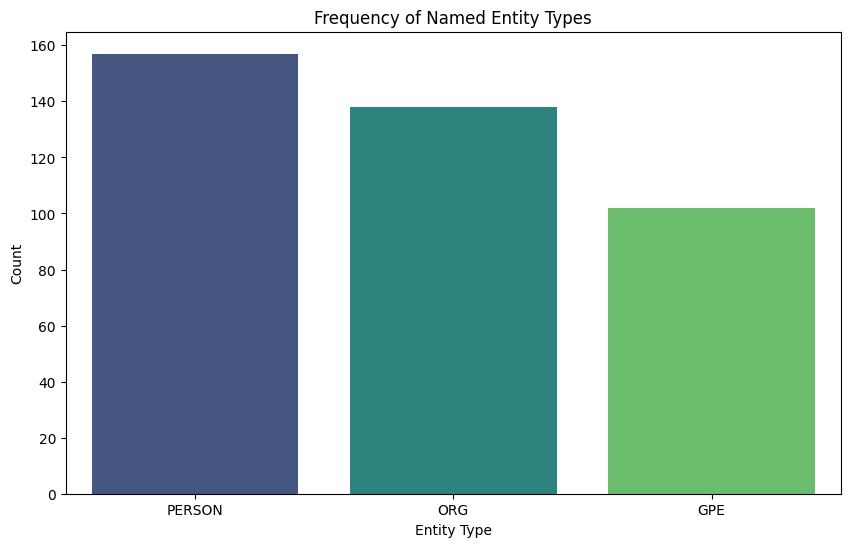

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

entity_counts = {
    'PERSON': df['PERSON_count'].sum(),
    'ORG': df['ORG_count'].sum(),
    'GPE': df['GPE_count'].sum()
}

entity_counts_df = pd.DataFrame(list(entity_counts.items()), columns=['Entity', 'Count'])

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Entity', y='Count', data=entity_counts_df, palette='viridis')
plt.title('Frequency of Named Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.show()

#####**2. Scatter Plot: Relationship Between Sentiment and Article Engagement**

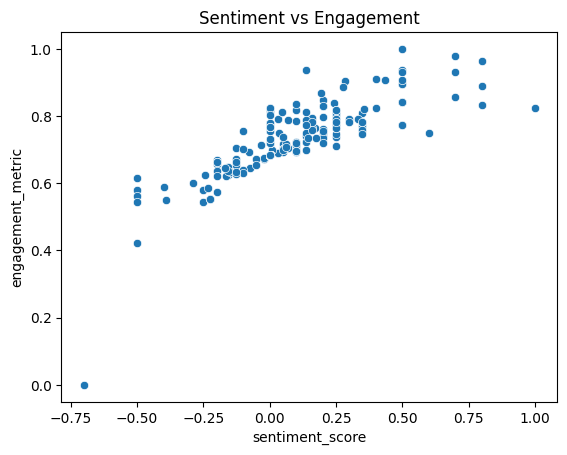

In [22]:
sns.scatterplot(data=df, x='sentiment_score', y='engagement_metric')
plt.title("Sentiment vs Engagement")
plt.show()

#####**3. Heatmap: Correlation Between Entity Counts and Engagement Metric**

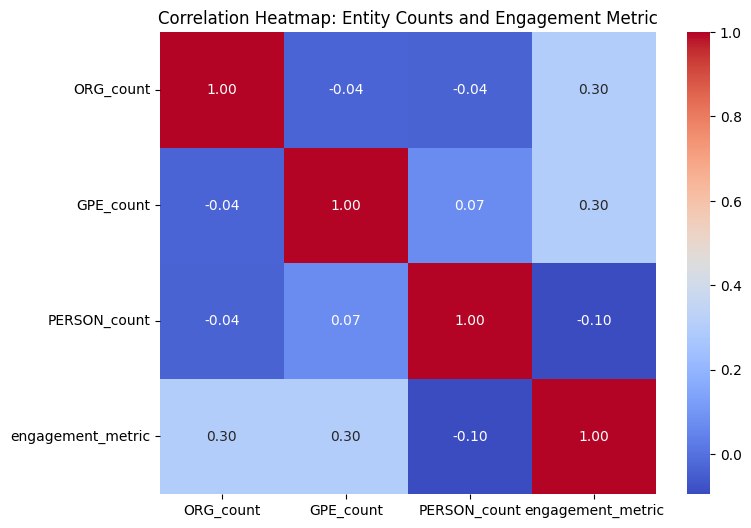

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns for correlation
correlation_data = df[['ORG_count', 'GPE_count', 'PERSON_count', 'engagement_metric']]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap: Entity Counts and Engagement Metric")
plt.show()